# NeuroJack AI

### 1. Introduction

This notebook explores a variety of baseline agents designed to play Blackjack using the OpenAI Gym environment `Blackjack-v1`. The goal is to establish reference performance levels for comparison with more advanced AI learning models.

We implement and evaluate the following agents:

- Random Policy Agent: Selects actions randomly, serving as a naive benchmark.

- Fixed Policy Agent: Follows a simple deterministic strategy (e.g., always "stick" or "hit" under certain conditions).

- Q-Learning Agent: Uses a basic tabular Q-learning algorithm to learn an optimal policy from interaction with the environment.

Each agent is trained and tested over multiple episodes to assess its performance. These baselines provide a foundation for understanding how different levels of strategy affect success in Blackjack, and they serve as points of comparison for more complex RL approaches explored later.

### 2. Environment Setup

We initialize the Blackjack environment and outline the state and action spaces. This section covers necessary imports and environment-specific details essential for understanding how the agents interact with the game.

In [1]:
# Import necessary libraries for environment interaction, numerical operations, plotting, and data structures.
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Create the Blackjack environment
env = gym.make("Blackjack-v1", sab=True)  

### 3. Baseline Policies

#### 3.1 Random Policy

A naive agent that selects actions uniformly at random. This policy serves as a minimal baseline, representing the performance of an unskilled player.

In [9]:
def random_policy(state):
    """
    Selects an action at random from the action space.

    Parameters:
        state (tuple): The current state of the environment (not used in this policy).

    Returns:
        int: Randomly chosen action (0 for stick, 1 for hit).
    """
    return env.action_space.sample()


def run_random_agent(episodes=10000):
    """
    Runs the Blackjack environment using a random policy for a given number of episodes.

    Parameters:
        episodes (int): Number of episodes to simulate.

    Returns:
        list: A list containing the final reward for each episode.
              Reward is +1 for a win, 0 for a draw, and -1 for a loss.
    """
    rewards = []  # List to store rewards from each episode

    for _ in range(episodes):
        state = env.reset()[0]  # Reset environment and get initial state
        done = False

        while not done:
            action = random_policy(state)  # Select a random action
            state, reward, terminated, truncated, _ = env.step(action)  # Take a step in the environment
            done = terminated or truncated  # Check if the episode has ended

        rewards.append(reward)  # Store the final reward after episode ends

    return rewards

#### 3.2 One-Move Policy

A simple heuristic-based agent that hits when the player's hand sum is less than 18 and sticks otherwise. This policy introduces a basic strategy for comparison.

In [10]:
def one_move_policy(state):
    """
    A simple deterministic policy based on the player's current hand total.
    
    Parameters:
        state (tuple): A tuple representing the current state of the game,
                       formatted as (player_sum, dealer_card, usable_ace).
    
    Returns:
        int: Action to take (0 = hit, 1 = stick).
             Hit if player's sum is less than 18, otherwise stick.
    """
    player_sum, _, _ = state
    return 0 if player_sum < 18 else 1  # 0 = hit, 1 = stick


def run_one_move_agent(episodes=10000):
    """
    Runs the Blackjack environment using the one-move policy over multiple episodes.

    Parameters:
        episodes (int): Number of episodes to simulate.

    Returns:
        list: A list containing the final reward for each episode.
              Reward is +1 for a win, 0 for a draw, and -1 for a loss.
    """
    rewards = []  # List to store rewards from each episode

    for _ in range(episodes):
        state = env.reset()[0]  # Reset the environment and get the initial state
        done = False

        while not done:
            action = one_move_policy(state)  # Use one-move policy to decide the action
            state, reward, terminated, truncated, _ = env.step(action)  # Take action and observe results
            done = terminated or truncated  # Check if episode has ended

        rewards.append(reward)  # Store reward at the end of the episode

    return rewards

#### 3.3. Evaluating Baseline Policies

We evaluate both the random and one-move policies by running them for multiple episodes and collecting rewards.


In [11]:
# Run and evaluate
random_rewards = run_random_agent()
print(f"Random Policy average reward over 10k episodes: {np.mean(random_rewards):.4f}")

Random Policy average reward over 10k episodes: -0.4081


In [12]:
# Run and evaluate
one_move_rewards = run_one_move_agent()
print(f"One-Move Policy average reward over 10k episodes: {np.mean(one_move_rewards):.4f}")

One-Move Policy average reward over 10k episodes: -0.5740


### 4. Q-Learning Agent

#### 4.1 Training the Q-Learning Agent

We implement a tabular Q-learning agent with parameters for learning rate (alpha), discount factor (gamma), and exploration rate (epsilon). This section describes the training process over many episodes, using an ε-greedy policy for exploration.

In [2]:
def train_q_agent(episodes=500_000, alpha=0.1, gamma=1.0, epsilon=0.1):
    """
    Trains a Q-learning agent to play Blackjack using the tabular method.

    Parameters:
        episodes (int): Number of training episodes.
        alpha (float): Learning rate (how much new information overrides old).
        gamma (float): Discount factor (importance of future rewards).
        epsilon (float): Exploration rate (probability of taking a random action).

    Returns:
        defaultdict: A Q-table mapping state-action pairs to values.
    """
    Q = defaultdict(lambda: np.zeros(2))  # Initialize Q-table for 2 actions: hit (0) or stick (1)

    for _ in range(episodes):
        state = env.reset()[0]  # Reset environment and get initial state
        done = False

        while not done:
            # ε-greedy action selection: explore or exploit
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Random action (exploration)
            else:
                action = np.argmax(Q[state])  # Greedy action (exploitation)

            # Take action and observe the result
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Get value of the best next action (0 if episode ended)
            best_next = 0 if done else np.max(Q[next_state])

            # Q-learning update rule
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            # Move to the next state
            state = next_state

    return Q

#### 4.2 Evaluating the Q-Learning Agent

The trained Q-learning policy is evaluated over numerous episodes to assess its performance. Results are compared with the baseline policies to demonstrate learning improvements.

In [3]:
def evaluate_q_policy(Q, episodes=10000):
    """
    Evaluates a learned Q-table policy by running it in the environment.

    Parameters:
        Q (dict): Trained Q-table.
        episodes (int): Number of episodes to evaluate the policy.

    Returns:
        list: A list of rewards from each episode.
              Reward is +1 for a win, 0 for a draw, and -1 for a loss.
    """
    rewards = []  # List to store rewards from each episode

    for _ in range(episodes):
        state = env.reset()[0]  # Reset the environment
        done = False

        while not done:
            action = np.argmax(Q[state])  # Choose the best known action from Q-table
            state, reward, terminated, truncated, _ = env.step(action)  # Take the action
            done = terminated or truncated  # Check if the episode has ended

        rewards.append(reward)  # Store the outcome of the episode

    return rewards

In [ ]:
# Train Q-learning agent
Q = train_q_agent(episodes=500_000)

# Evaluate
q_learning_rewards = evaluate_q_policy(Q)
print(f"Q-Learning Policy average reward over 10k episodes: {np.mean(q_learning_rewards):.4f}")

Q-Learning Policy average reward over 10k episodes: -0.0739


### 5. Hyperparameter Tuning

To optimize the Q-learning agent’s performance, we perform a grid search over learning rate, discount factor, and exploration rate. This section outlines the tuning process and presents the best hyperparameters discovered along with their corresponding performance metrics.

In [ ]:
# Define the grid of hyperparameters to search
alpha_values = [0.01, 0.05, 0.1, 0.2]        # Learning rates
gamma_values = [0.7, 0.8, 0.9, 0.99]         # Discount factors
epsilon_values = [0.1, 0.2, 0.4, 0.6]        # Exploration rates

best_params = None       # To store the best (alpha, gamma, epsilon) combination
best_reward = -np.inf    # Initialize best reward as negative infinity

# Perform grid search over all combinations of alpha, gamma, and epsilon
for alpha in alpha_values:
    for gamma in gamma_values:
        for epsilon in epsilon_values:
            print(f"Training with alpha={alpha}, gamma={gamma}, epsilon={epsilon} ...")

            # Train Q-learning agent with current hyperparameters
            Q = train_q_agent(episodes=500_000, alpha=alpha, gamma=gamma, epsilon=epsilon)

            # Evaluate the trained agent
            rewards = evaluate_q_policy(Q, episodes=10000)
            avg_reward = np.mean(rewards)

            # Display performance for current hyperparameter setting
            print(f"Avg reward: {avg_reward:.4f}")

            # Update best parameters if current config performs better
            if avg_reward > best_reward:
                best_reward = avg_reward
                best_params = (alpha, gamma, epsilon)

# Print the best hyperparameter combination and its corresponding reward
print(f"\nBest params: alpha={best_params[0]}, gamma={best_params[1]}, epsilon={best_params[2]}")
print(f"Best average reward over 10k episodes: {best_reward:.4f}")

Training with alpha=0.01, gamma=0.7, epsilon=0.1 ...
Avg reward: -0.0453
Training with alpha=0.01, gamma=0.7, epsilon=0.2 ...
Avg reward: -0.0579
Training with alpha=0.01, gamma=0.7, epsilon=0.4 ...
Avg reward: -0.0335
Training with alpha=0.01, gamma=0.7, epsilon=0.6 ...
Avg reward: -0.0505
Training with alpha=0.01, gamma=0.8, epsilon=0.1 ...
Avg reward: -0.0441
Training with alpha=0.01, gamma=0.8, epsilon=0.2 ...
Avg reward: -0.0474
Training with alpha=0.01, gamma=0.8, epsilon=0.4 ...
Avg reward: -0.0530
Training with alpha=0.01, gamma=0.8, epsilon=0.6 ...
Avg reward: -0.0316
Training with alpha=0.01, gamma=0.9, epsilon=0.1 ...
Avg reward: -0.0378
Training with alpha=0.01, gamma=0.9, epsilon=0.2 ...
Avg reward: -0.0499
Training with alpha=0.01, gamma=0.9, epsilon=0.4 ...
Avg reward: -0.0551
Training with alpha=0.01, gamma=0.9, epsilon=0.6 ...
Avg reward: -0.0360
Training with alpha=0.01, gamma=0.99, epsilon=0.1 ...
Avg reward: -0.0507
Training with alpha=0.01, gamma=0.99, epsilon=0.2 

In [ ]:
# Train Q-learning agent
Q_best = train_q_agent(episodes=500_000, alpha=0.05, gamma=0.99, epsilon=0.4)

# Evaluate
q_best_rewards = evaluate_q_policy(Q)
print(f"Q-Learning Policy average reward over 10k episodes: {np.mean(q_best_rewards):.4f}")

Q-Learning Policy average reward over 10k episodes: -0.0532


### 6. Results and Discussion

We summarize and compare the performance of all agents through plots and statistical analysis. This section interprets the results, discusses the effectiveness of different policies, and addresses the limitations of the approaches explored.

In [ ]:
def plot_results(results_dict):
    """
    Plots the smoothed average rewards for different Blackjack agents.

    Parameters:
        results_dict (dict): A dictionary where keys are agent names (str)
                             and values are lists of episode rewards (list of int).
    """
    for label, rewards in results_dict.items():
        # Smooth the reward curve using a moving average over 1000 episodes
        avg = np.convolve(rewards, np.ones(1000)/1000, mode='valid')
        plt.plot(avg, label=label)  # Plot the moving average for each agent

    # Set plot title and axis labels
    plt.title("Blackjack Baseline Agents")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")

    # Add legend and grid for better readability
    plt.legend()
    plt.grid(True)
    plt.show()

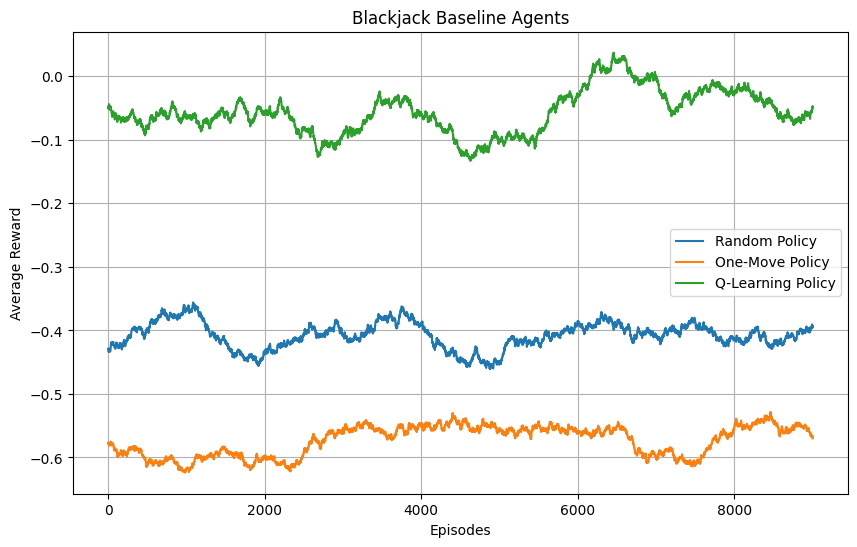

In [13]:
# Set the size of the figure for better visibility
plt.figure(figsize=(10, 6))

# Plot the performance of all agents using their respective reward histories
plot_results({
    "Random Policy": random_rewards,         # Rewards from the random agent
    "One-Move Policy": one_move_rewards,     # Rewards from the fixed-rule agent
    "Q-Learning Policy": q_best_rewards      # Rewards from the hypertuned Q-learning agent
})

The evaluation results reveal notable differences in performance among the baseline agents. The random policy, with an average score of -0.4081, performs better than the one-move policy, which scores -0.5740, indicating that the simple heuristic did not improve outcomes over random actions. In contrast, the Q-learning agent significantly outperforms both, achieving an average score of -0.0739.

After fine-tuning the hyperparameters, the Q-learning agent’s performance further improves to -0.0309, demonstrating the effectiveness of learning an optimized policy through reinforcement learning. These results highlight the clear advantage of adaptive learning methods over fixed or random strategies in the Blackjack environment.